# Example using pdf function instead of sampling

In [1]:
import pymc4 as pm
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

One can draw a pdf from a distribution easily via tensorflow.

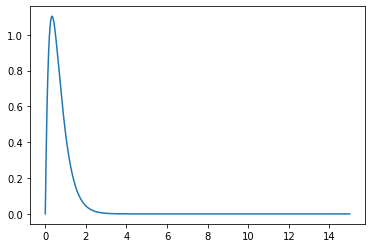

In [112]:
dist = tfp.distributions.Gamma(
    name="g",
    concentration=2,
    rate=3
)
x = np.arange(0,15,0.001)
pdf = dist.prob(x)
norm = tf.keras.utils.normalize(pdf) # Calculates L2 norm
# the norm messes with our shape so we need to reshape
norm =tf.reshape(
    norm, (15000), name=None
)

plt.plot(x,pdf)

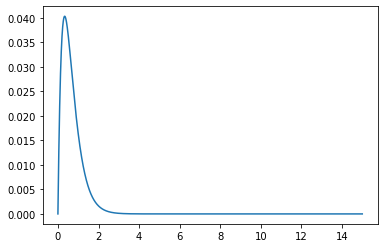

In [113]:
plt.plot(x,norm)

That is also possible with pymc4 but not inside a model!

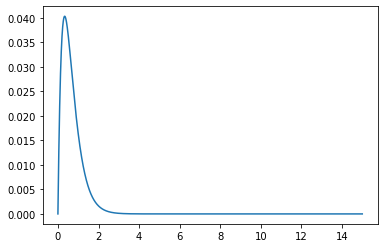

In [114]:
dist = pm.Gamma(
    name="g",
    concentration=2,
    rate=3
)
pdf = dist._distribution.prob(x)
norm = tf.keras.utils.normalize(pdf)
norm =tf.reshape(
    norm, (15000), name=None
)
plt.plot(x,norm)

In [115]:
tf.range(0,14)

<tf.Tensor: shape=(14,), dtype=int32, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
      dtype=int32)>

Lets try this inside a model

In [116]:
tf.compat.v1.enable_eager_execution()
x = np.arange(0,15,0.001)
@pm.model
def model(data):
    g_mu = yield pm.Gamma(name="g_mu", concentration=4.8/0.04, rate=0.04)
    
    g_theta = yield pm.Gamma(
        name="g_theta", concentration=0.8/0.1, rate=0.1
    )

    g = tfp.distributions.Gamma(
        name="g",
        concentration=g_mu/g_theta,
        rate=1/g_theta
    )
    pdf = g.prob([0,1,2,3,4])
    norm = tf.keras.utils.normalize(pdf) # Calculates L2 norm
    print(norm.shape)
    return g_theta

In [117]:
mod = model(None)
trace = pm.sample(model(None))

(1, 5)


NotImplementedError: Cannot convert a symbolic Tensor (g_1/prob/Exp:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [26]:
trace


Inference data with groups:
	> posterior
	> sample_stats

LKJ R

In [118]:
infected_vector = tf.convert_to_tensor([1000,1500,500,2500],dtype="float32")

contacts = tfp.distributions.LKJ(
    dimension=4,
    concentration=0
)

R_t = contacts.sample()

R_t = tf.keras.utils.normalize(R_t,axis=0)
R_t = tf.keras.utils.normalize(R_t,axis=1)
c = tf.linalg.diag([1.0,2.0,3.0,4.0])

factor = tf.matmul(c,tf.matmul(R_t,c))
I_next  = factor

In [119]:
print(infected_vector)
print(f"{c} \n * \n{R_t} \n*\n {c} \n= ")
print(I_next)

tf.Tensor([1000. 1500.  500. 2500.], shape=(4,), dtype=float32)
[[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]] 
 * 
[[ 0.7192437   0.14593285 -0.43188673 -0.5242767 ]
 [ 0.12981603  0.8761116   0.3474043   0.3080365 ]
 [-0.42020282  0.3799698   0.72738785  0.38724592]
 [-0.52050495  0.34378842  0.39515007  0.67434454]] 
*
 [[1. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 4.]] 
= 
tf.Tensor(
[[ 0.7192437   0.2918657  -1.2956603  -2.0971067 ]
 [ 0.25963205  3.5044465   2.084426    2.464292  ]
 [-1.2606084   2.2798188   6.5464907   4.646951  ]
 [-2.0820198   2.7503073   4.741801   10.789513  ]], shape=(4, 4), dtype=float32)


# Example for the LKJ matrix posterior with pymc4
Easy model using I_new = c*I_old,
whereby R=1 and c = LKJ()

In [74]:
import arviz as az

In [145]:
# 4 Age groups
I_init = np.array([1000.0,1500.0,2000.0,1500.0])
I_array = np.array([I_init + np.random.random(size=4)*250 for i in range(0,50)])
R_0 =  np.array([[1.0,0.2,0.4,0.3],
                [0.2,1.0,0.2,0.3],
                [0.4,0.2,1.0,0.3],
                [0.3,0.3,0.3,1.0]])

I_end = np.array([R_0@I_in for I_in in I_array])


@pm.model
def LKJ_model(data):
    #eta = yield pm.Uniform('nu', 0, 5)
    c = yield pm.LKJ(
        dimension=4,
        concentration=2,
        name="LKJ"
    )
    print(c)
    estimate = tf.linalg.matvec(c, tf.convert_to_tensor(I_array,dtype="float32"))
    like = yield pm.Normal(loc=estimate,scale=20,observed=data,name="like")
    

In [146]:
trace = pm.sample(LKJ_model(I_end), num_samples=10,num_chains=5)

tf.Tensor(
[[ 1.         -0.14098871  0.29460305 -0.38938567]
 [-0.14098871  1.         -0.39985687 -0.04387863]
 [ 0.29460305 -0.39985687  1.          0.4722308 ]
 [-0.38938567 -0.04387863  0.4722308   1.        ]], shape=(4, 4), dtype=float32)
Tensor("values_0:0", shape=(4, 4), dtype=float32)
Tensor("values_0:0", shape=(4, 4), dtype=float32)


In [147]:
a = trace.posterior.data_vars.get("LKJ_model/LKJ")
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [148]:
b = np.array(a)
print("Estimate of I to next timestep:")
print(tf.linalg.matvec(tf.convert_to_tensor(b[1,-1],dtype="float32"),tf.convert_to_tensor(I_init,dtype="float32")).numpy())
print("Given data on I next timestep:")
print(I_end)

Estimate of I to next timestep:
[2551.3452 2549.586  3155.676  2857.5474]
Given data on I next timestep:
[[2833.23265627 2761.02665978 3473.875449   3169.7625753 ]
 [2887.49185075 2684.38949346 3480.01560054 3082.70587858]
 [2843.86066004 2765.2609068  3313.46595109 3103.63580841]
 [2819.86610859 2756.17909886 3463.623473   3025.39425258]
 [2710.2424532  2772.71270301 3422.78936784 2994.39442728]
 [2776.20353122 2659.64827161 3369.38497927 3101.28838822]
 [2733.89733356 2739.34338553 3348.47693284 3011.54383299]
 [2694.73139323 2832.49466433 3313.99512145 3052.57579065]
 [2696.92205523 2615.94058577 3263.35865112 2994.95377414]
 [2890.15587141 2843.33829506 3410.77468636 3168.37043142]
 [2788.98144965 2706.09249236 3388.08097881 3011.3899899 ]
 [2702.37609422 2629.3898934  3314.663774   2973.38445611]
 [2701.09127151 2674.50317014 3236.28500828 2964.44404189]
 [2740.81860722 2856.5607632  3324.43370288 3107.42478833]
 [2788.58808926 2799.39202957 3440.44517264 3182.94554076]
 [2779.960

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc9dc427e90>,
      dtype=object)

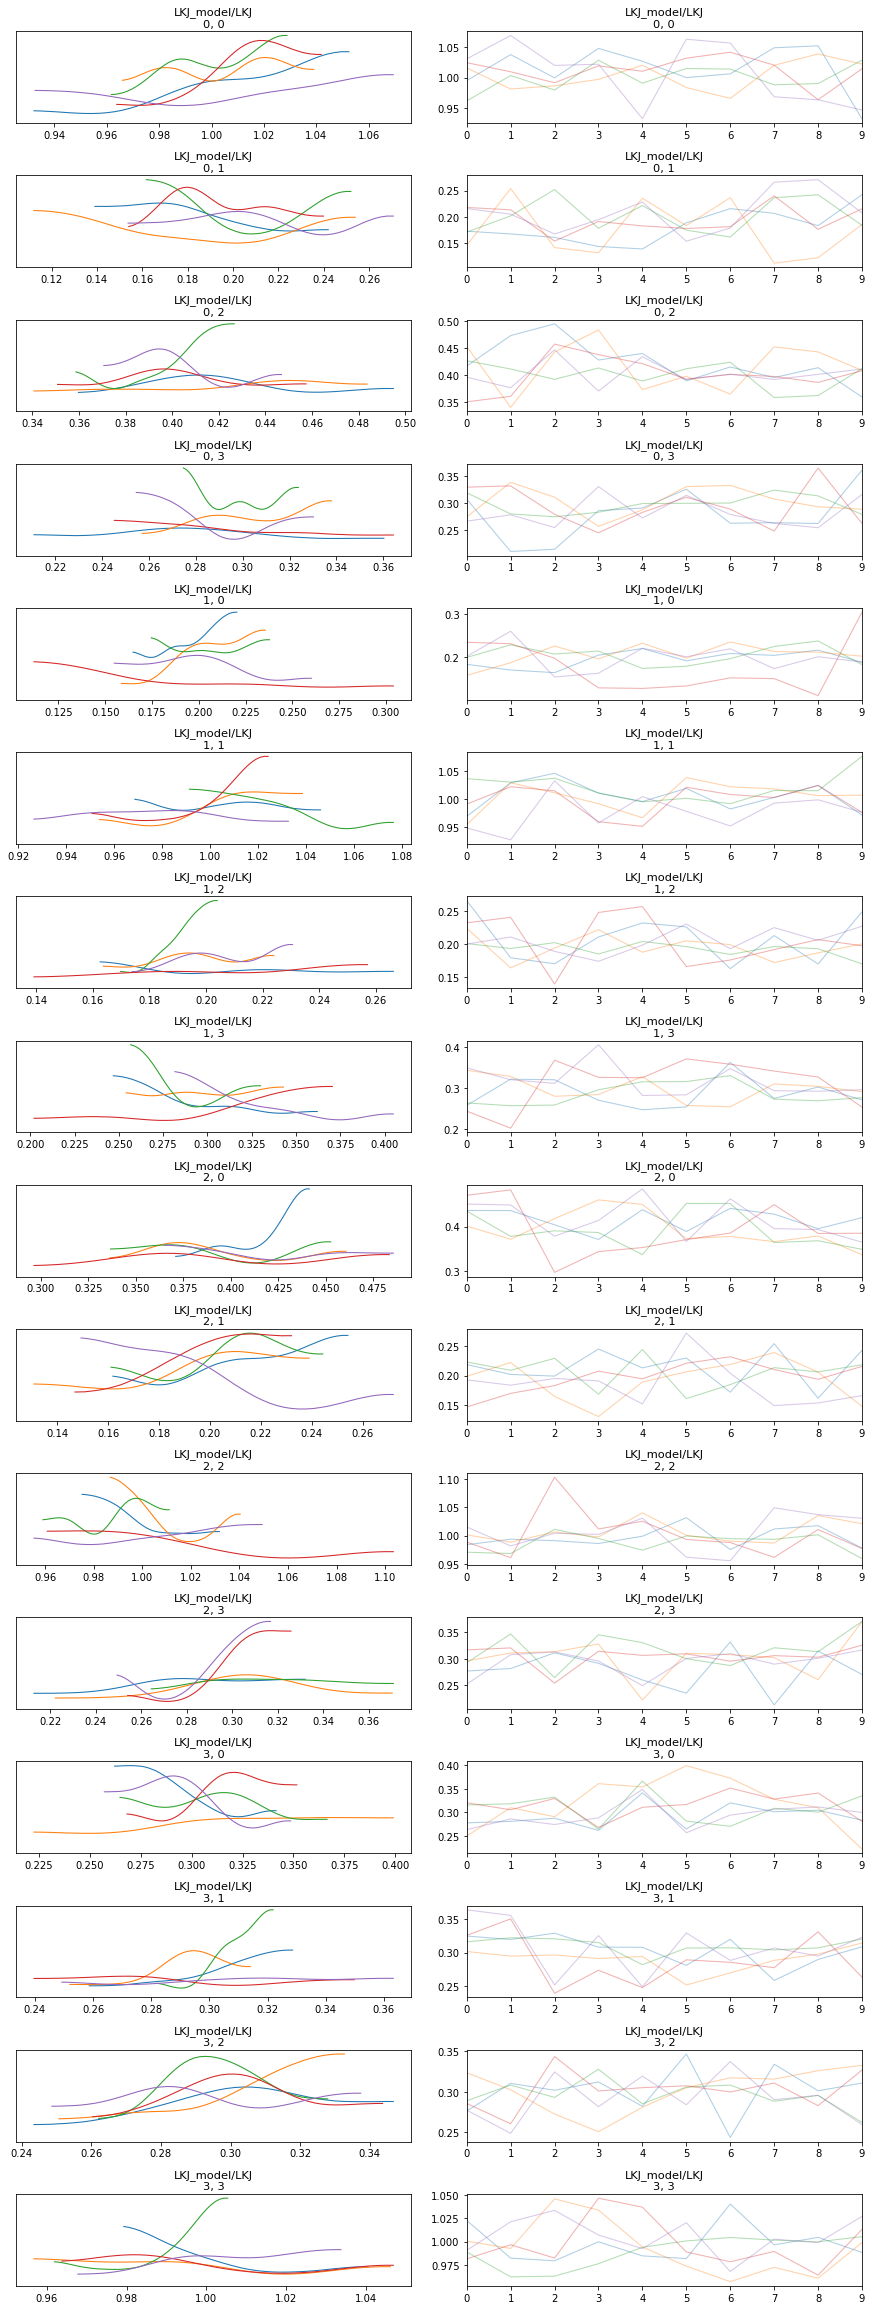

In [149]:
az.plot_trace(trace)


# Trying to create diagonal matrix from pymc4 RV

In [94]:
def describe_distributions(distributions):
  print('\n'.join([str(d) for d in distributions]))

In [121]:
l=5
@pm.model
def diag_R():
    R = yield pm.Normal(
        #R_0:
        loc=[2]*4, #Defining the batch stack here works fine but with
        #batch_stack = 4,
        #loc=2,
        # DOES NOT WORK
        scale=2.5,
        name="R_age_groups"
        )
    R_diag = tf.linalg.diag(R)
    print(R)
    print(R_diag)
trace = pm.sample(diag_R(), num_samples=8,num_chains=4)

tf.Tensor([ 2.0797968 -1.1058669  2.0906272  4.0058584], shape=(4,), dtype=float32)
tf.Tensor(
[[ 2.0797968  0.         0.         0.       ]
 [ 0.        -1.1058669  0.         0.       ]
 [ 0.         0.         2.0906272  0.       ]
 [ 0.         0.         0.         4.0058584]], shape=(4, 4), dtype=float32)
Tensor("values_0:0", shape=(4,), dtype=float32)
Tensor("diag:0", shape=(4, 4), dtype=float32)
Tensor("values_0:0", shape=(4,), dtype=float32)
Tensor("diag:0", shape=(4, 4), dtype=float32)


# Norm of a vector

In [13]:
v = tf.convert_to_tensor([2,1,4,2,1,10],[2,1,1,2,3,dtype="float32")
norm = tf.norm(v,1)
print(v)
print(norm)
print(tf.linalg.normalize(v,1))

tf.Tensor([ 2.  1.  4.  2.  1. 10.], shape=(6,), dtype=float32)
tf.Tensor(20.0, shape=(), dtype=float32)
(<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0.1 , 0.05, 0.2 , 0.1 , 0.05, 0.5 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([20.], dtype=float32)>)


# Small PMC4 model with scan function

In [1]:
import pymc4 as pm
import tensorflow as tf
import numpy as np

In [5]:
data = [5]
for i in range(1,10):
    data.append(data[i-1]*(1+0.4)**i)
print(f"data:\n{data}")    

def get_new(R_t,I_0):
    @tf.function
    def next_day(new,R_t):
        print("-------------")
        print(f"new:\n{new}")
        print(f"R_t:\n{R_t}")
        
        # Next time step
        new = new * R_t

        # Return
        return new
    
    #Start scan function
    initial_values = I_0
    iterate_elements = R_t
    
    new_cases = tf.scan(fn=next_day,elems=iterate_elements,initializer=initial_values)    
    
    return tf.transpose(new_cases)

@pm.model
def test_model(data):
    
    #Construct R
    R_0 = yield pm.LogNormal(name="R_0",loc=1,scale=2,conditionaly_independent=True)
    print(f"R_0:\n{R_0}")
    R_t = tf.stack([R_0]*10)
    print(f"R_t:\n{R_t}")
    
    #Construct I_0
    I_0 = yield pm.HalfCauchy(name="I_0", loc=0, scale= 25,conditionaly_independent=True)
    print(f"I_0:\n{I_0}")
    
    new_cases = get_new(R_t,I_0)
    print(f"new_cases:\n{new_cases}")
    
    data_transf=np.array(data, dtype='float32')
    print(f"data shape: {data_transf.shape}")
    likelihood = yield pm.StudentT(
        name="like", loc=new_cases, scale=100, df=4, observed=data_transf, reinterpreted_batch_ndims = 1
    )
    return 'Finished'

trace = pm.sample(test_model(data), num_samples=50, burn_in=80, num_chains=3, use_auto_batching=False)
    
    


data:
[5, 7.0, 13.719999999999999, 37.64767999999999, 144.62732748799993, 777.8404777890605, 5856.777879769929, 61738.347845623866, 911127.7808609284, 18824853.70656973]
R_0:
1.0
R_t:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
I_0:
1.0
-------------
new:
Tensor("new:0", shape=(), dtype=float32)
R_t:
Tensor("R_t:0", shape=(), dtype=float32)
new_cases:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
data shape: (10,)
[<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]
R_0:
Tensor("exp_1/forward/Exp:0", shape=(3,), dtype=float32)
R_t:
Tensor("stack:0", shape=(10, 3), dtype=float32)
I_0:
Tensor("exp_2_1/forward/Exp:0", shape=(3,), dtype=float32)
-------------
new:
Tensor("new:0", shape=(3,), dtype=float32)
R_t:
Tensor("R_t:0", shape=(3,), dtype=float32)
new_cases:
Tensor("transpose:0", shape=(3, 10), dtype=float32)
data shape: (10,)
R_0:
Tensor("exp_1/forward/Exp:0", shape=(3,), dtype=float32)
R_t:
Tensor

In [6]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [52]:
a = tf.constant([1,4])
b = tf.constant([5])
tensors = [a,b]

In [53]:
tf.stack([tf.expand_dims(t, 1) for t in tensors],1)

InvalidArgumentError: Shapes of all inputs must match: values[0].shape = [2,1] != values[1].shape = [1,1] [Op:Pack] name: stack